## Task 3.1 Convergence and attractors

In [1]:
import numpy as np

#### Initialize some data from lab instructions

In [2]:
x1=np.array([-1, -1, 1, -1, 1, -1, -1, 1])
x2=np.array([-1, -1, -1, -1, -1, 1, -1, -1])
x3=np.array([-1, 1, 1, -1, -1, 1, -1, 1])

x1d=np.array([ 1, -1, 1, -1, 1, -1, -1, 1])
x2d=np.array([ 1, 1, -1, -1, -1, 1, -1, -1])
x3d=np.array([ 1, 1, 1, -1, 1, 1, -1, 1,])

#### Synchronous Hopfield - note, all data is in row format

In [ ]:
class Hopfield_net():
    def __init__(self, data, scale=False):
        self.data = data
        self.W = np.zeros((data.shape[1], data.shape[1]))
        self.scale = scale
        self.hebian_learn()

    def hebian_learn(self):
        for i in range(self.data.shape[0]):
            self.W += np.outer(self.data[i], self.data[i])
        if self.scale:
            self.W /= self.data.shape[0]

    # Numpy sign sets sign of 0 to 0 - change it to 1
    def hop_sign(self, dp):
        temp = np.sign(dp)
        return np.where(temp == 0, 1, temp)
    
    def recall_sync(self, dp):
        recall_prev = np.copy(dp)
        recall = self.hop_sign(np.matmul(np.copy(dp), self.W))
        while not np.array_equal(recall, recall_prev):
            recall_prev = np.copy(recall)
            recall = self.hop_sign(np.matmul(recall, self.W))
        return recall.astype(int)

    def recall_seq(self, dp, random=False):
        order = np.arange(dp.shape[0])
        if random:
            np.random.shuffle(order)
        recall_prev = np.copy(dp)
        recall = self.seq_update(dp, order)
        while not np.array_equal(recall, recall_prev):
            if random:
                np.random.shuffle(order)
            recall_prev = np.copy(recall)
            recall = self.seq_update(recall, order)
        return recall.astype(int)

    # Helper func to sequential update - makes one pass of sequential updates for all points
    def seq_update(self, recall, order):
        ret = np.copy(recall)
        for i in range(order.shape[0]):
            ret[order[i]] = self.hop_sign(np.matmul(self.W[order[i]], ret.transpose()))
        return ret

#### Some test funcs to see if recall recalls properly

In [4]:
def test_recall_sync(data, data_dist, test_net=None, printout=True):
    if test_net is None:
        test_net = Hopfield_net(data)
    for i in range(data.shape[0]):
        recalled = test_net.recall_sync(data_dist[i])
        did_recall = np.array_equal(data[i], recalled)
        print("x{} recalled properly: {}".format(i + 1, did_recall))
        if not did_recall and printout:
            print("\torig: {}".format(np.array2string(data[i])))
            print("\tdist: {}".format(np.array2string(data_dist[i])))
            print("\trecl: {}".format(np.array2string(recalled)))

def test_recall_seq(data, data_dist, test_net=None, printout=True):
    if test_net is None:
        test_net = Hopfield_net(data)
    for i in range(data.shape[0]):
        recalled = test_net.recall_seq(data_dist[i])
        did_recall = np.array_equal(data[i], recalled)
        print("x{} recalled properly: {}".format(i + 1, did_recall))
        if not did_recall and printout:
            print("\torig: {}".format(np.array2string(data[i])))
            print("\tdist: {}".format(np.array2string(data_dist[i])))
            print("\trecl: {}".format(np.array2string(recalled))) 

##### Some sanity checks

In [5]:
data = np.vstack((x1, x2, x3))
test_recall_sync(data, data)
test_recall_seq(data, data)

x1 recalled properly: True
x2 recalled properly: True
x3 recalled properly: True
x1 recalled properly: True
x2 recalled properly: True
x3 recalled properly: True


###  Actual 3.1

#### Check convergence of distorted data points

In [6]:
data = np.vstack((x1, x2, x3))
data_dist = np.vstack((x1d, x2d, x3d))
test_recall_sync(data, data_dist)
test_recall_seq(data, data_dist)

x1 recalled properly: True
x2 recalled properly: False
	orig: [-1 -1 -1 -1 -1  1 -1 -1]
	dist: [ 1  1 -1 -1 -1  1 -1 -1]
	recl: [-1  1 -1 -1 -1  1 -1 -1]
x3 recalled properly: True
x1 recalled properly: True
x2 recalled properly: False
	orig: [-1 -1 -1 -1 -1  1 -1 -1]
	dist: [ 1  1 -1 -1 -1  1 -1 -1]
	recl: [-1  1 -1 -1 -1  1 -1 -1]
x3 recalled properly: True


#### Check for all attractors

In [7]:
# Please change this if you get a better idea than to brute force it with all possible input vectors
def dp_builder(dim):
    vec = np.zeros(dim)
    return dp_builder_h(dim, vec, 0)
def dp_builder_h(dim, curr_vec, curr_ind):
    # Need to copy so vec2 does not mess this up later
    vec1 = np.copy(curr_vec)
    vec1[curr_ind] = 1
    # Don't need to copy since no one else will use curr_vec
    vec2 = curr_vec
    vec2[curr_ind] = -1
    # Base case, reached last index of vector
    if dim == curr_ind + 1:
        return np.vstack((vec1, vec2))
    else:
        return np.vstack((
            dp_builder_h(dim, vec1, curr_ind + 1),
            dp_builder_h(dim, vec2, curr_ind + 1)
        ))        

In [8]:
data = np.vstack((x1, x2, x3))
test_net = Hopfield_net(data)
all_dp = dp_builder(x1.shape[0])
attractors = np.zeros(all_dp.shape)

# Brute force it - recall for every possible input vector
for i in range(all_dp.shape[0]):
    attractors[i] = test_net.recall_sync(all_dp[i])

# Remove duplicates
attractors = np.unique(attractors, axis=0)
print(attractors)
print("In total {} attractors".format(attractors.shape[0]))
    

[[-1. -1. -1. -1. -1.  1. -1. -1.]
 [-1. -1. -1. -1.  1. -1. -1. -1.]
 [-1. -1.  1. -1. -1.  1. -1.  1.]
 [-1. -1.  1. -1.  1. -1. -1.  1.]
 [-1. -1.  1. -1.  1.  1. -1.  1.]
 [-1.  1. -1. -1. -1.  1. -1. -1.]
 [-1.  1.  1. -1. -1.  1. -1.  1.]
 [-1.  1.  1. -1.  1. -1. -1.  1.]
 [ 1. -1. -1.  1.  1. -1.  1. -1.]
 [ 1.  1. -1.  1. -1.  1.  1. -1.]
 [ 1.  1. -1.  1.  1. -1.  1. -1.]
 [ 1.  1. -1.  1.  1.  1.  1. -1.]
 [ 1.  1.  1.  1. -1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1. -1.  1.  1.]]
In total 14 attractors


#### Testing even more distorted patterns

In [9]:
# Flip first 5 
x1_superd=np.copy(x1)
for i in range(x1.size // 2 + 1):
    x1_superd[i] = x1_superd[i] * -1

test_recall_sync(x1.reshape((1, -1)), x1_superd.reshape((1, -1)), test_net)
    

x1 recalled properly: False
	orig: [-1 -1  1 -1  1 -1 -1  1]
	dist: [ 1  1 -1  1 -1 -1 -1  1]
	recl: [ 1  1  1  1  1 -1  1  1]


## 3.2 Sequential Update

#### Load the data

In [ ]:
file_path_pic_data = 'datasets/pict.dat'

num_pics = 11
num_attrs = 1024

# Open file and read in the array from string to int
raw_data = []
with open(file_path_pic_data, 'r') as file:
    for line in file:
        raw_data = list(map(int, line.split(',')))
        # It should only be a single line but just in case
        break
pic_data = np.array(raw_data).reshape(num_pics, num_attrs)

# Sanity check that we did the reshaping right
for i in range(num_pics):
    for j in range(num_attrs):
        if raw_data[num_attrs*i + j] != pic_data[i, j]:
            print("Error, reshape incorrect!")

pic_data_dist = pic_data[9:]
pic_data = pic_data[:9] # pattern p10 is a degraded version of p1 and p11 is a degraded version of p2 and p3

In [20]:
pic_data.shape

(9, 1024)

#### Define function for drawing the pictures

In [14]:
import matplotlib.pyplot as plt

def show_image_from_vec(dp, title=None):
    im_data = dp.reshape(32, 32)
    plt.imshow(im_data)
    if title is not None:
        plt.title(title)
    plt.show()

#### Train with 3 pictures

In [16]:
pic_data_3 = pic_data[:3]
test_recall_seq(pic_data_3, pic_data_3)

x1 recalled properly: True
x2 recalled properly: True
x3 recalled properly: True


#### With random recall the picture recalls properly - with non-random it lands in a spurious attractor

Recalled x1: False


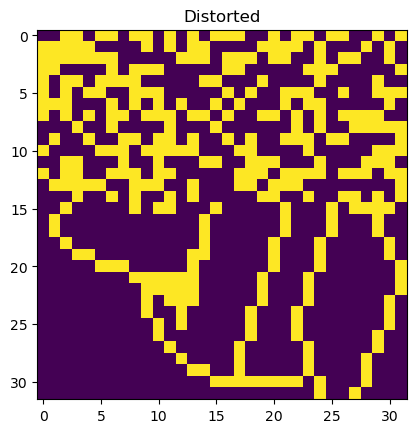

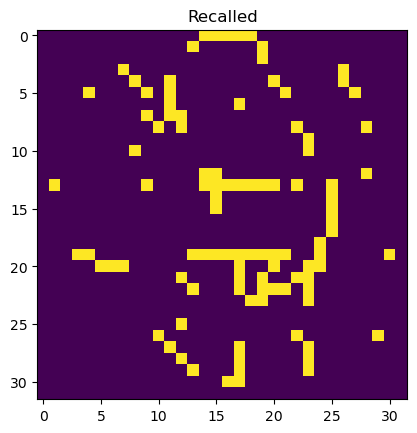

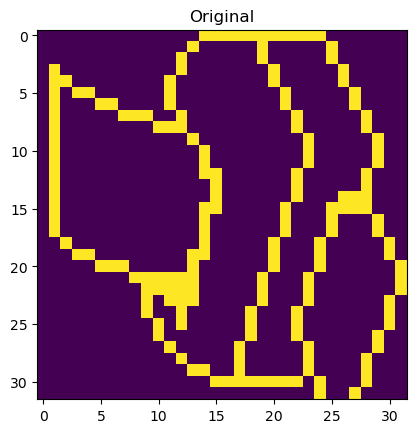

In [17]:
pic_net = Hopfield_net(pic_data_3)
#test_recall_seq(pic_data_3[0].reshape((1, -1)), pic_data_dist[0].reshape((1, -1)), printout=False, test_net=pic_net)
did_recall_x1 = np.array_equal(pic_data_3[0], pic_net.recall_seq(pic_data_dist[0]))
print("Recalled x1: {}".format(did_recall_x1))
show_image_from_vec(pic_data_dist[0], title="Distorted")
show_image_from_vec(pic_net.recall_seq(pic_data_dist[0]), title="Recalled")
show_image_from_vec(pic_data_3[0], title="Original")


### Check the other distorted pic

Recalled x2: True
Recalled x3: False


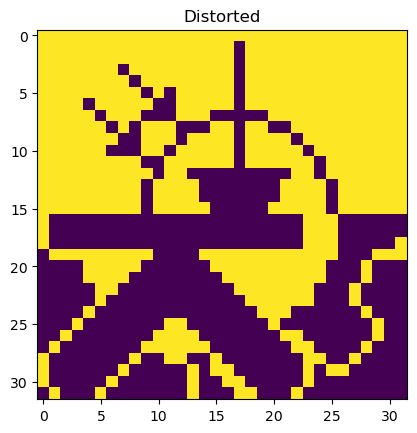

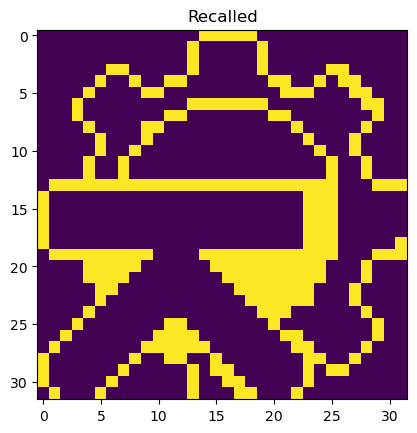

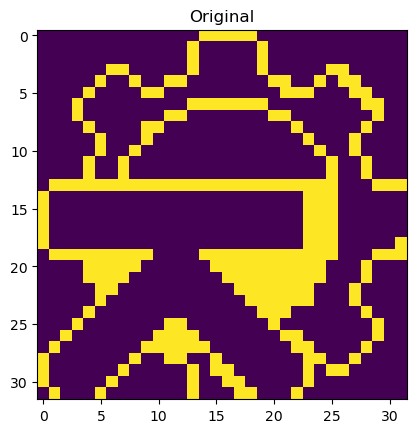

In [21]:
#pic_dist = np.vstack((pic_data_dist[1], pic_data_dist[1])).reshape((2, -1))
#test_recall_seq(pic_data_3[1:2].reshape((2, -1)), pic_dist, printout=False, test_net=pic_net)

did_recall_x2 = np.array_equal(pic_data_3[1], pic_net.recall_seq(pic_data_dist[1]))
did_recall_x3 = np.array_equal(pic_data_3[2], pic_net.recall_seq(pic_data_dist[1]))
print("Recalled x2: {}".format(did_recall_x2))
print("Recalled x3: {}".format(did_recall_x3))
show_image_from_vec(pic_data_dist[1], title="Distorted")
show_image_from_vec(pic_net.recall_seq(pic_data_dist[1]), title="Recalled")
show_image_from_vec(pic_data_3[1], title="Original")

### Make a new Hopfield net since they want us to print during recall - less messy (but still messy)

In [ ]:
class Hopfield_net_pics(Hopfield_net):
    def __init__(self, data, scale=False):
        super().__init__(data, scale=scale)
        self.it = 0
        
    # Overwrite to print pictures
    def seq_update(self, recall, order):
        ret = np.copy(recall)
        for i in range(order.shape[0]):
            if self.it % 100 == 0:
                show_image_from_vec(ret, title="Recall after {} iterations".format(self.it))
            ret[order[i]] = self.hop_sign(np.matmul(self.W[order[i]], ret.transpose()))
            self.it += 1
        return ret

### With random pic 0 gets spurious and pic 1 recalls 1 - without random vice versa

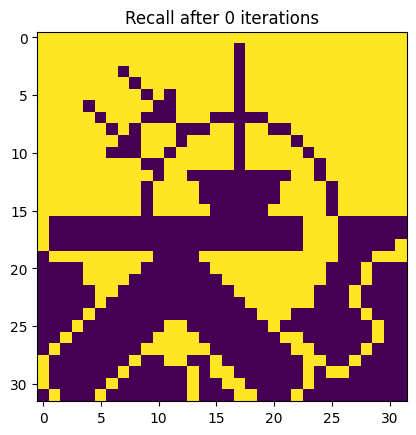

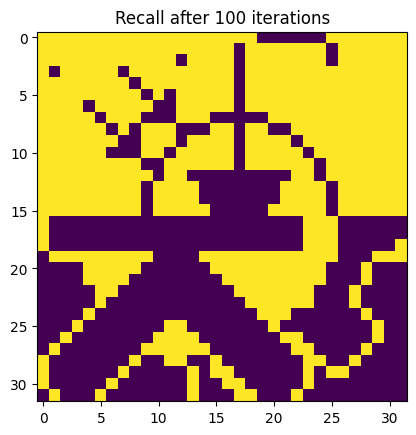

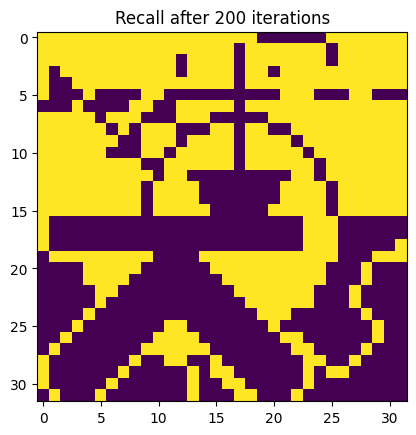

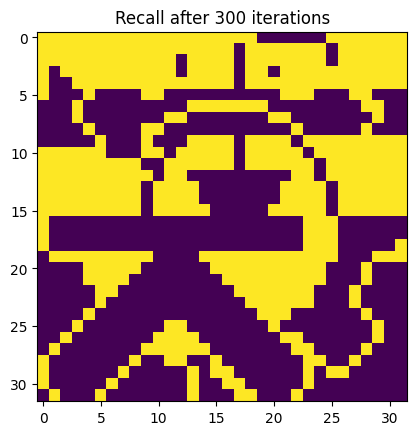

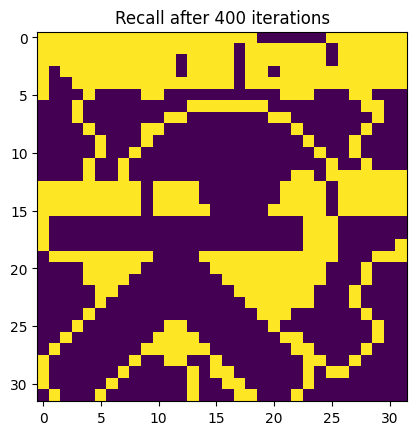

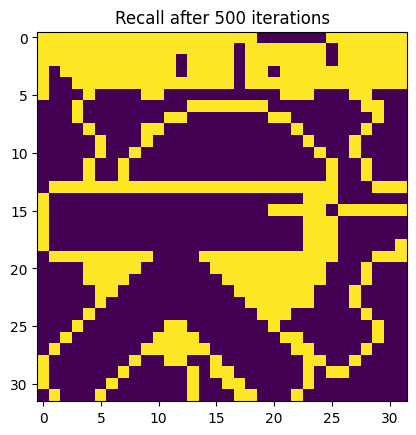

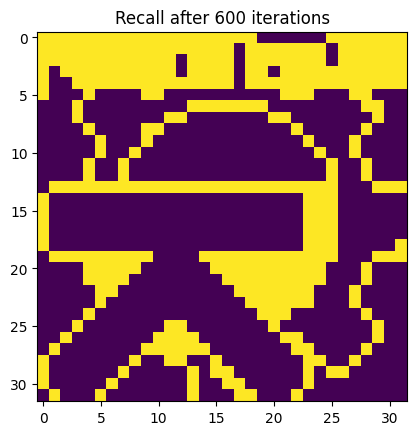

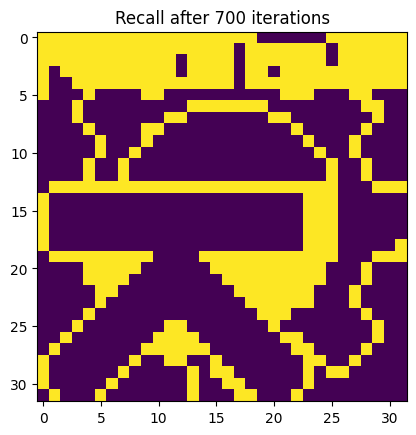

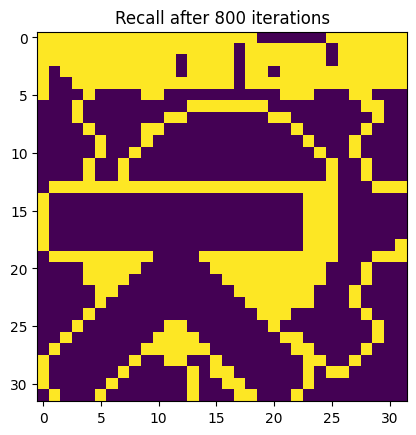

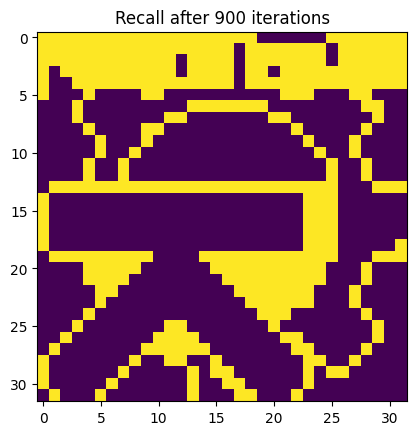

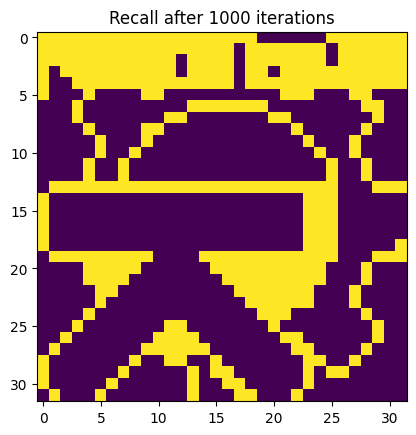

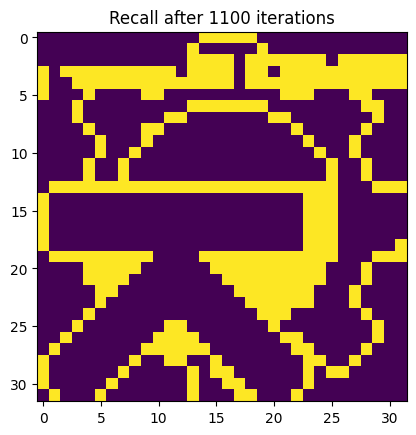

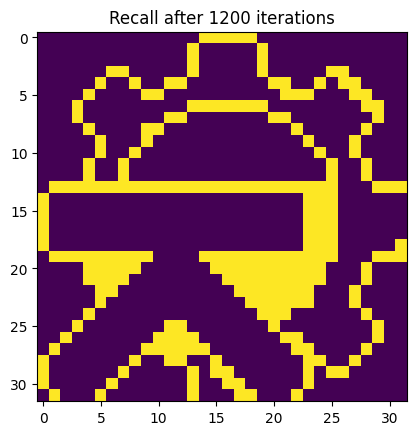

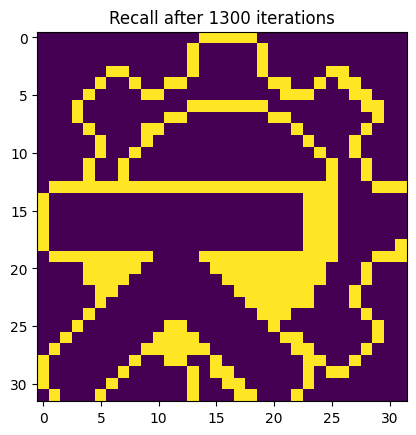

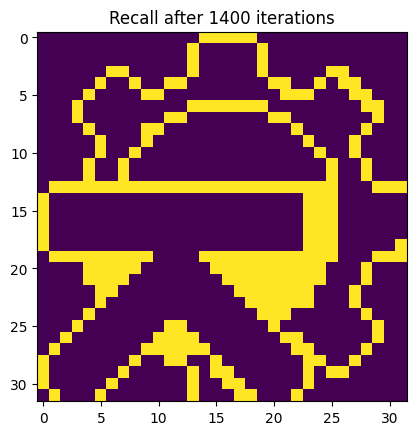

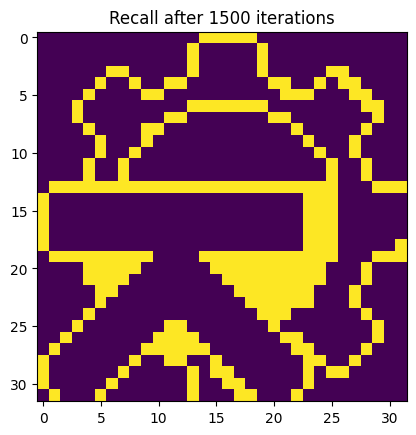

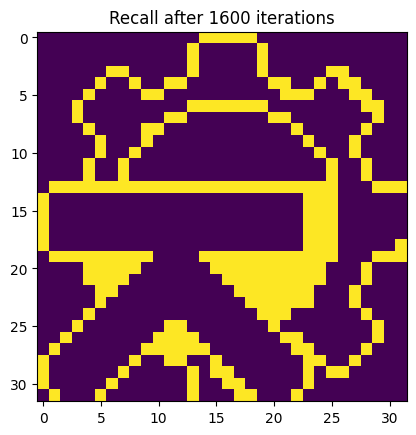

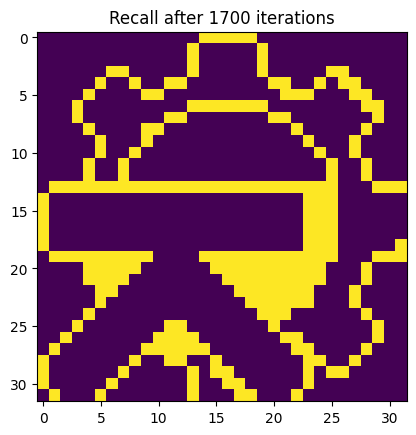

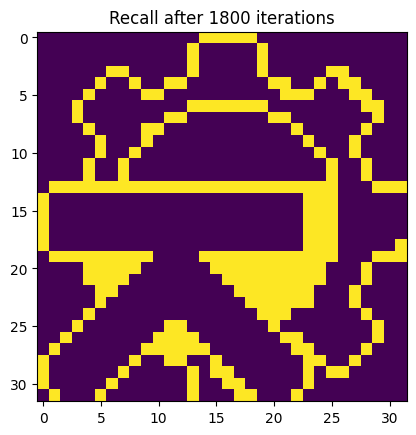

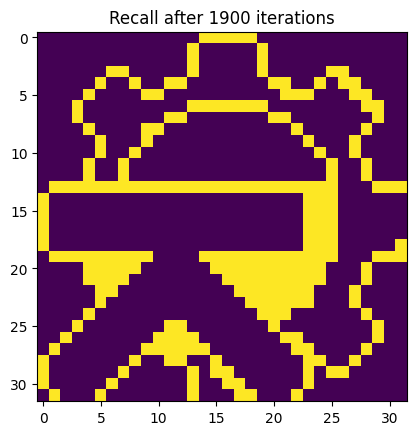

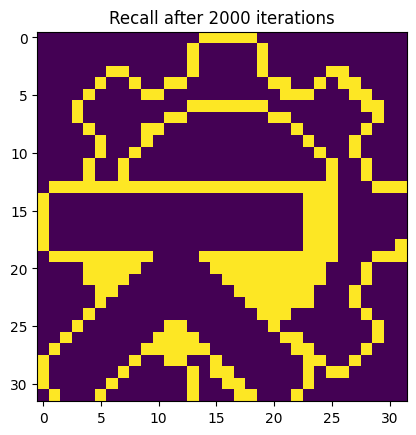

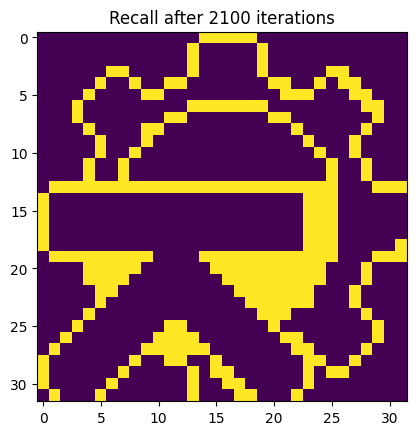

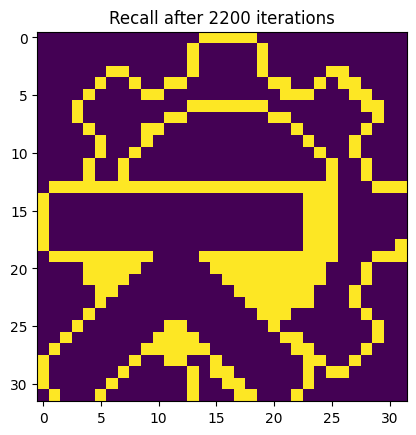

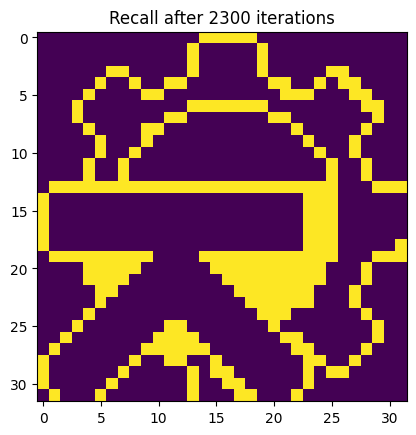

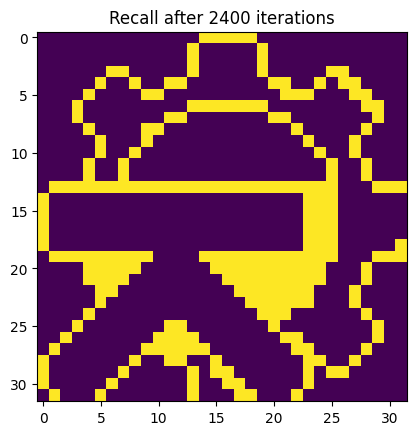

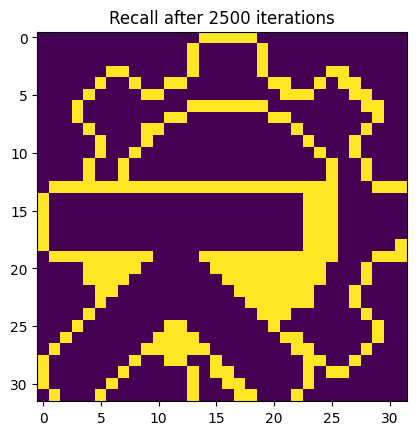

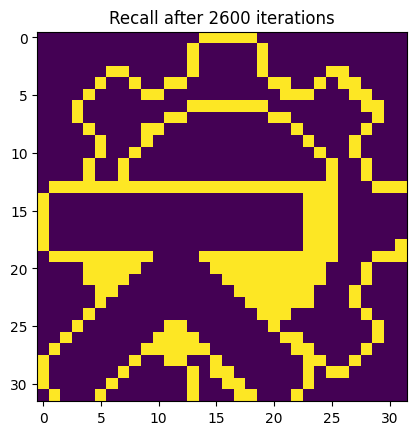

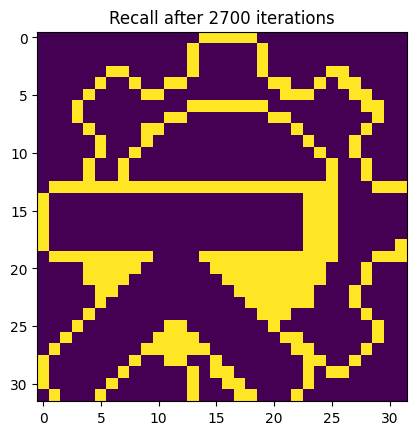

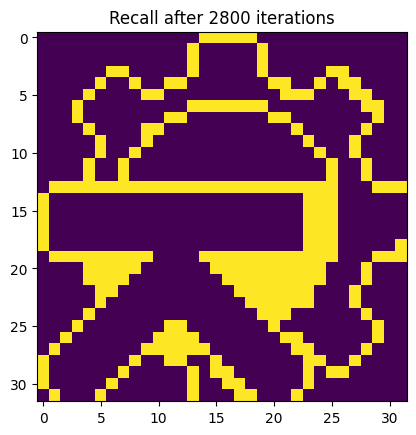

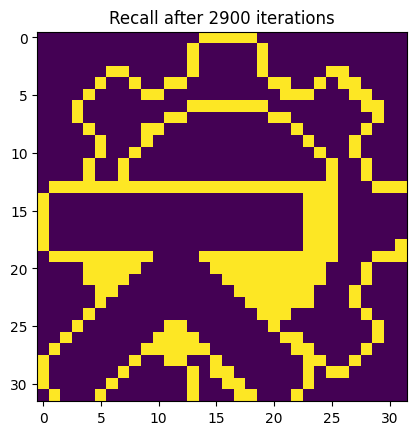

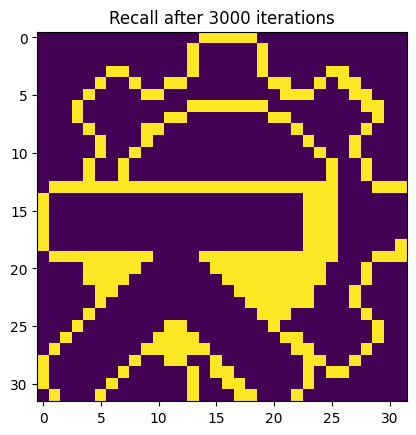

In [52]:
pic_net_printing = Hopfield_net_pics(pic_data_3)

printed_end = pic_net_printing.recall_seq(pic_data_dist[1])

## 3.3 Energy

In [103]:
# overwrite to include energy calculations
class Hopfield_net_energy(Hopfield_net):
    def __init__(self, data, scale=False):
        super().__init__(data, scale=scale)

    def calculate_energy(self, X):

       return - np.sum(self.W * np.outer(X,X))
       
    def recall_seq(self, dp, random=False):
        order = np.arange(dp.shape[0])
        energy_history = []

        if random:
            np.random.shuffle(order)
        recall_prev = np.copy(dp)
        recall = self.seq_update(dp, order, energy_history=energy_history)
        while not np.array_equal(recall, recall_prev):
            if random:
                np.random.shuffle(order)
            recall_prev = np.copy(recall)
            recall = self.seq_update(recall, order, energy_history=energy_history)

        return recall.astype(int), energy_history
    
     # Helper func to sequential update - makes one pass of sequential updates for all points
    def seq_update(self, recall, order, energy_history):
        ret = np.copy(recall)
        for i in range(order.shape[0]):
            ret[order[i]] = self.hop_sign(np.matmul(self.W[order[i]], ret.transpose()))
            energy_history.append(self.calculate_energy(ret))
        return ret

### What is the energy at different atractors?

In [104]:
data = np.vstack((x1, x2, x3))
test_net = Hopfield_net_energy(data)
all_dp = dp_builder(x1.shape[0])
attractors = np.zeros(all_dp.shape)

# Brute force it - recall for every possible input vector
for i in range(all_dp.shape[0]):
    attractors[i], _  = test_net.recall_seq(all_dp[i])

# Remove duplicates
attractors = np.unique(attractors, axis=0)
print(attractors)
print("In total {} attractors".format(attractors.shape[0]))
    

[[-1. -1. -1. -1. -1.  1. -1. -1.]
 [-1. -1. -1. -1.  1. -1. -1. -1.]
 [-1. -1.  1. -1. -1.  1. -1.  1.]
 [-1. -1.  1. -1.  1. -1. -1.  1.]
 [-1. -1.  1. -1.  1.  1. -1.  1.]
 [-1.  1. -1. -1. -1.  1. -1. -1.]
 [-1.  1.  1. -1. -1.  1. -1.  1.]
 [-1.  1.  1. -1.  1. -1. -1.  1.]
 [ 1. -1. -1.  1.  1. -1.  1. -1.]
 [ 1.  1. -1.  1. -1.  1.  1. -1.]
 [ 1.  1. -1.  1.  1. -1.  1. -1.]
 [ 1.  1. -1.  1.  1.  1.  1. -1.]
 [ 1.  1.  1.  1. -1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1. -1.  1.  1.]]
In total 14 attractors


In [105]:
for attractor in attractors: 
    energy = test_net.calculate_energy(attractor)
    print(f"The energy for attractor{attractor} is {energy}")


The energy for attractor[-1. -1. -1. -1. -1.  1. -1. -1.] is -68.0
The energy for attractor[-1. -1. -1. -1.  1. -1. -1. -1.] is -36.0
The energy for attractor[-1. -1.  1. -1. -1.  1. -1.  1.] is -68.0
The energy for attractor[-1. -1.  1. -1.  1. -1. -1.  1.] is -68.0
The energy for attractor[-1. -1.  1. -1.  1.  1. -1.  1.] is -56.0
The energy for attractor[-1.  1. -1. -1. -1.  1. -1. -1.] is -56.0
The energy for attractor[-1.  1.  1. -1. -1.  1. -1.  1.] is -72.0
The energy for attractor[-1.  1.  1. -1.  1. -1. -1.  1.] is -56.0
The energy for attractor[ 1. -1. -1.  1.  1. -1.  1. -1.] is -72.0
The energy for attractor[ 1.  1. -1.  1. -1.  1.  1. -1.] is -68.0
The energy for attractor[ 1.  1. -1.  1.  1. -1.  1. -1.] is -68.0
The energy for attractor[ 1.  1. -1.  1.  1.  1.  1. -1.] is -56.0
The energy for attractor[ 1.  1.  1.  1. -1.  1.  1.  1.] is -36.0
The energy for attractor[ 1.  1.  1.  1.  1. -1.  1.  1.] is -68.0


### What is the energy on at the points of the distorted patterns?

In [106]:
# patterns
x1=np.array([-1, -1, 1, -1, 1, -1, -1, 1])
x2=np.array([-1, -1, -1, -1, -1, 1, -1, -1])
x3=np.array([-1, 1, 1, -1, -1, 1, -1, 1])

x1d=np.array([ 1, -1, 1, -1, 1, -1, -1, 1])
x2d=np.array([ 1, 1, -1, -1, -1, 1, -1, -1])
x3d=np.array([ 1, 1, 1, -1, 1, 1, -1, 1,])

In [107]:
def test_recall_seq(data, data_dist, test_net=None, printout=True):
    if test_net is None:
        test_net = Hopfield_net(data)
    for i in range(data.shape[0]):
        recalled, _  = test_net.recall_seq(data_dist[i])
        did_recall = np.array_equal(data[i], recalled)
        print("x{} recalled properly: {}".format(i + 1, did_recall))
        if not did_recall and printout:
            print("\torig: {}".format(np.array2string(data[i])))
            print("\tdist: {}".format(np.array2string(data_dist[i])))
            print("\trecl: {}".format(np.array2string(recalled)))


test_recall_seq(data=data, data_dist=data_dist, test_net=test_net)

x1 recalled properly: True
x2 recalled properly: False
	orig: [-1 -1 -1 -1 -1  1 -1 -1]
	dist: [ 1  1 -1 -1 -1  1 -1 -1]
	recl: [-1  1 -1 -1 -1  1 -1 -1]
x3 recalled properly: True


In [108]:
data = np.vstack((x1,x2,x3))
data_dist = np.vstack((x1d,x2d,x3d))

test_net = Hopfield_net_energy(data)


test_recall_seq(data=data, data_dist=data_dist, test_net=test_net)

for i, x in enumerate(data_dist):
    #print(x)
    energy = test_net.calculate_energy(x)
    print(f"The energy for the disorted patter of x{i+1} is {energy}")

x1 recalled properly: True
x2 recalled properly: False
	orig: [-1 -1 -1 -1 -1  1 -1 -1]
	dist: [ 1  1 -1 -1 -1  1 -1 -1]
	recl: [-1  1 -1 -1 -1  1 -1 -1]
x3 recalled properly: True
The energy for the disorted patter of x1 is -40.0
The energy for the disorted patter of x2 is -36.0
The energy for the disorted patter of x3 is -24.0


### What is the energy on at the points of the original patterns?

In [109]:
data = np.vstack((x1,x2,x3))
data_dist = np.vstack((x1d,x2d,x3d))

test_net = Hopfield_net_energy(data)


test_recall_seq(data=data, data_dist=data, test_net=test_net)

for i, x in enumerate(data):
    #print(x)
    energy = test_net.calculate_energy(x)
    print(f"The energy for the disorted patter of x{i+1} is {energy}")

x1 recalled properly: True
x2 recalled properly: True
x3 recalled properly: True
The energy for the disorted patter of x1 is -68.0
The energy for the disorted patter of x2 is -68.0
The energy for the disorted patter of x3 is -72.0


**Conparing this to the calculated energies of all attractors makes reasonable sense as these are the overall lowest energies, with an exception that there is one other attractor (not part of the training data) that also has energy -72.0.**

### Plot energy changes from interation to interaton when using sequential updates

[[np.float64(-425964.0), np.float64(-425964.0), np.float64(-430144.0), np.float64(-434348.0), np.float64(-434348.0), np.float64(-438576.0), np.float64(-442828.0), np.float64(-442828.0), np.float64(-447104.0), np.float64(-451404.0), np.float64(-451404.0), np.float64(-455728.0), np.float64(-455728.0), np.float64(-460076.0), np.float64(-461840.0), np.float64(-461840.0), np.float64(-461840.0), np.float64(-461840.0), np.float64(-463628.0), np.float64(-463760.0), np.float64(-463760.0), np.float64(-463916.0), np.float64(-463916.0), np.float64(-463916.0), np.float64(-464096.0), np.float64(-468460.0), np.float64(-472848.0), np.float64(-472848.0), np.float64(-472848.0), np.float64(-477260.0), np.float64(-477260.0), np.float64(-481696.0), np.float64(-486156.0), np.float64(-490640.0), np.float64(-495148.0), np.float64(-499680.0), np.float64(-504236.0), np.float64(-504236.0), np.float64(-504236.0), np.float64(-504236.0), np.float64(-504236.0), np.float64(-508816.0), np.float64(-508816.0), np.float6

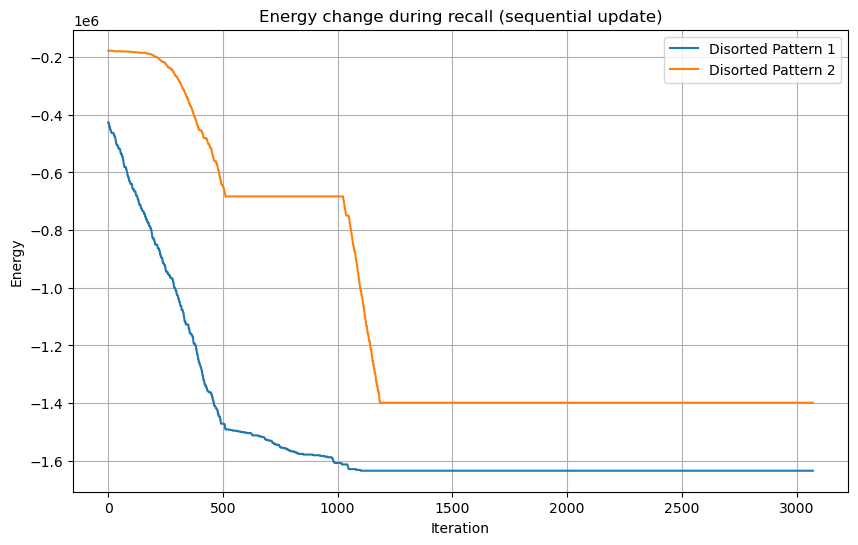

In [110]:
pic_data_3 = pic_data[:3]
pic_net = Hopfield_net_energy(data=pic_data_3)

energy_list = []

for i, x in enumerate(pic_data_dist):
    recall,energy  = pic_net.recall_seq(x)
    energy_list.append(energy)


print(energy_list)

plt.figure(figsize=(10,6))

for i, energy_history in enumerate(energy_list):
    plt.plot(energy_history, label=f'Disorted Pattern {i+1}')

plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Energy change during recall (sequential update)')
plt.legend()
plt.grid(True)
plt.show()

In [120]:
# same class but with weights initialised normal 
class Hopfield_net_energy(Hopfield_net):
    def __init__(self, data, scale=False):
        super().__init__(data, scale=scale)
        np.random.seed(42)
        self.W= np.random.normal(loc=0, scale=1.0, size = (data.shape[1],data.shape[1])) # setting weights to normal distribution and diagonal weights to 0
        np.fill_diagonal(self.W,0)
        

    def calculate_energy(self, X):

       return - np.sum(self.W * np.outer(X,X))
       
    def recall_seq(self, dp, random=False):
        order = np.arange(dp.shape[0])
        energy_history = []

        if random:
            np.random.shuffle(order)
        recall_prev = np.copy(dp)
        recall = self.seq_update(dp, order, energy_history=energy_history)
        while not np.array_equal(recall, recall_prev):
            if random:
                np.random.shuffle(order)
            recall_prev = np.copy(recall)
            recall = self.seq_update(recall, order, energy_history=energy_history)

        return recall.astype(int), energy_history
    
     # Helper func to sequential update - makes one pass of sequential updates for all points
    def seq_update(self, recall, order, energy_history):
        ret = np.copy(recall)
        for i in range(order.shape[0]):
            ret[order[i]] = self.hop_sign(np.matmul(self.W[order[i]], ret.transpose()))
            energy_history.append(self.calculate_energy(ret))
        return ret

In [121]:
pic_data_3 = pic_data[:3]
pic_net = Hopfield_net_energy(data=pic_data_3)

energy_list = []

for i, x in enumerate(pic_data_dist):
    recall,energy  = pic_net.recall_seq(x)
    energy_list.append(energy)


print(energy_list)

plt.figure(figsize=(10,6))

for i, energy_history in enumerate(energy_list):
    plt.plot(energy_history, label=f'Disorted Pattern {i+1}')

plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Energy change during recall (sequential update)')
plt.legend()
plt.grid(True)
plt.show()

KeyboardInterrupt: 

**Observations**

- Never (5 mins tested) coverged/found a stable state.
- To be expexted as weights are asymmetric unless explicitly symmetrized (symmetry ensures the existance of an energy function that decreases or stays constant)

### Setting weigths matrix symetric

Notes Sebastian: Symmetry refers to the property of the connection (weight) matrix $ W $, where $ w_{ij} = w_{ji} $ for all neurons $ i $ and $ j $ (i.e., the matrix is equal to its transpose, $ W = W^T $). This means the strength of the connection from neuron $ j $ to $ i $ is identical to the connection from $ i $ to $ j $, creating bidirectional, reciprocal links between neurons.

In [125]:
# same class but with weights initialised normal ans symmetric weight matrix
class Hopfield_net_energy(Hopfield_net):
    def __init__(self, data, scale=False):
        super().__init__(data, scale=scale)
        np.random.seed(42)
        self.W= np.random.normal(loc=0, scale=1.0, size = (data.shape[1],data.shape[1])) # setting weights to normal distribution and diagonal weights to 0
        np.fill_diagonal(self.W,0)
        self.W = 0.5 * (self.W*np.transpose(self.W))
        

    def calculate_energy(self, X):

       return - np.sum(self.W * np.outer(X,X))
       
    def recall_seq(self, dp, random=False):
        order = np.arange(dp.shape[0])
        energy_history = []

        if random:
            np.random.shuffle(order)
        recall_prev = np.copy(dp)
        recall = self.seq_update(dp, order, energy_history=energy_history)
        while not np.array_equal(recall, recall_prev):
            if random:
                np.random.shuffle(order)
            recall_prev = np.copy(recall)
            recall = self.seq_update(recall, order, energy_history=energy_history)

        return recall.astype(int), energy_history
    
     # Helper func to sequential update - makes one pass of sequential updates for all points
    def seq_update(self, recall, order, energy_history):
        ret = np.copy(recall)
        for i in range(order.shape[0]):
            ret[order[i]] = self.hop_sign(np.matmul(self.W[order[i]], ret.transpose()))
            energy_history.append(self.calculate_energy(ret))
        return ret

[[np.float64(760.9483945876447), np.float64(760.9483945876447), np.float64(748.8982775733211), np.float64(622.7666634665663), np.float64(537.2137720781147), np.float64(537.2137720781147), np.float64(537.2137720781147), np.float64(537.2137720781147), np.float64(518.9882946773134), np.float64(494.4920175279468), np.float64(489.5869249404345), np.float64(370.3461911937022), np.float64(370.3461911937022), np.float64(335.5777726996306), np.float64(292.4532439516031), np.float64(292.4532439516031), np.float64(292.4532439516031), np.float64(292.4532439516031), np.float64(292.4532439516031), np.float64(292.4532439516031), np.float64(292.4532439516031), np.float64(281.5167748177361), np.float64(281.5167748177361), np.float64(253.5481997733825), np.float64(251.50827638720088), np.float64(123.6307746537286), np.float64(123.6307746537286), np.float64(123.6307746537286), np.float64(74.01614662018144), np.float64(-22.487088613474185), np.float64(-22.487088613474185), np.float64(-22.487088613474185),

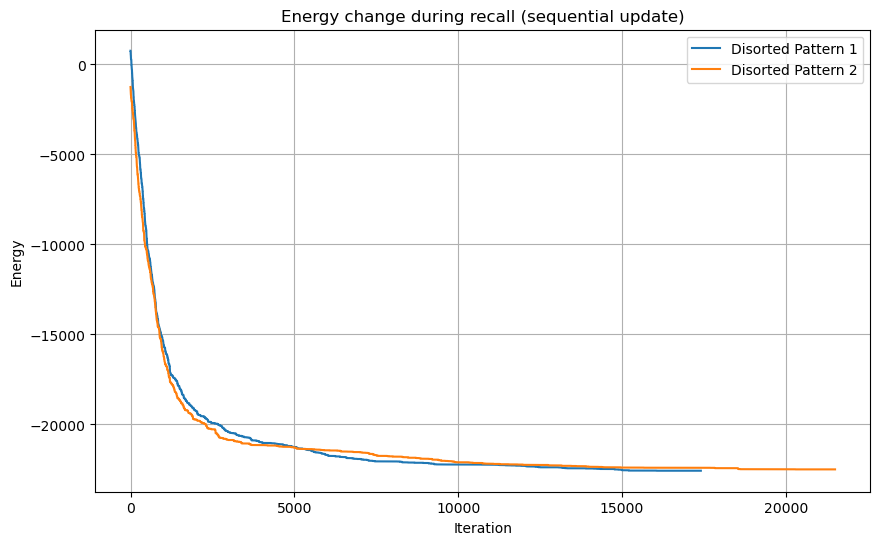

In [126]:
pic_data_3 = pic_data[:3]
pic_net = Hopfield_net_energy(data=pic_data_3)

energy_list = []

for i, x in enumerate(pic_data_dist):
    recall,energy  = pic_net.recall_seq(x)
    energy_list.append(energy)


print(energy_list)

plt.figure(figsize=(10,6))

for i, energy_history in enumerate(energy_list):
    plt.plot(energy_history, label=f'Disorted Pattern {i+1}')

plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Energy change during recall (sequential update)')
plt.legend()
plt.grid(True)
plt.show()

### 3.4 Distortion Resistance

In [166]:
class Hopfield_net():
    def __init__(self, data, scale=False):
        self.data = data
        self.W = np.zeros((data.shape[1], data.shape[1]))
        self.scale = scale
        self.hebian_learn()

    def hebian_learn(self):
        for i in range(self.data.shape[0]):
            self.W += np.outer(self.data[i], self.data[i])
        if self.scale:
            self.W /= self.data.shape[0]

    # Numpy sign sets sign of 0 to 0 - change it to 1
    def hop_sign(self, dp):
        temp = np.sign(dp)
        return np.where(temp == 0, 1, temp)
    
    def recall_sync(self, dp):
        recall_prev = np.copy(dp)
        recall = self.hop_sign(np.matmul(np.copy(dp), self.W))
        while not np.array_equal(recall, recall_prev):
            recall_prev = np.copy(recall)
            recall = self.hop_sign(np.matmul(recall, self.W))
        return recall.astype(int)

    def recall_seq(self, dp, random=False):
        order = np.arange(dp.shape[0])
        if random:
            np.random.shuffle(order)
        recall_prev = np.copy(dp)
        recall = self.seq_update(dp, order)
        while not np.array_equal(recall, recall_prev):
            if random:
                np.random.shuffle(order)
            recall_prev = np.copy(recall)
            recall = self.seq_update(recall, order)
        return recall.astype(int)

    # Helper func to sequential update - makes one pass of sequential updates for all points
    def seq_update(self, recall, order):
        ret = np.copy(recall)
        for i in range(order.shape[0]):
            ret[order[i]] = self.hop_sign(np.matmul(self.W[order[i]], ret.transpose()))
        return ret

In [167]:
def pic_noise(pic_data,noise_percentage):

    noisy_pic = np.copy(pic_data)
    n_pixels = noisy_pic.shape[0]
    n_flips = int(n_pixels*noise_percentage)

    np.random.seed(42)

    noise_indices = np.random.choice(n_pixels,size=n_flips, replace=False)

    noisy_pic[noise_indices] *= -1

    return noisy_pic


In [168]:
def calc_noise_removal(original_pic_data, noisy_pic_data, recalled_pic_data):


    corrupted_pixels = (original_pic_data != noisy_pic_data)
    n_corrupted = np.sum(corrupted_pixels)

    if n_corrupted == 0.0:
        return 100.0
    
    #figure out which of the corrupted pixels of the recalled image are equal to the correct image (calculate percentage of noise removal)
    fixed_pixels = (recalled_pic_data[corrupted_pixels] == original_pic_data[corrupted_pixels])
    n_fixed = np.sum(fixed_pixels)

    noise_removal_percentage = (n_fixed / n_corrupted) * 100
    
    return noise_removal_percentage

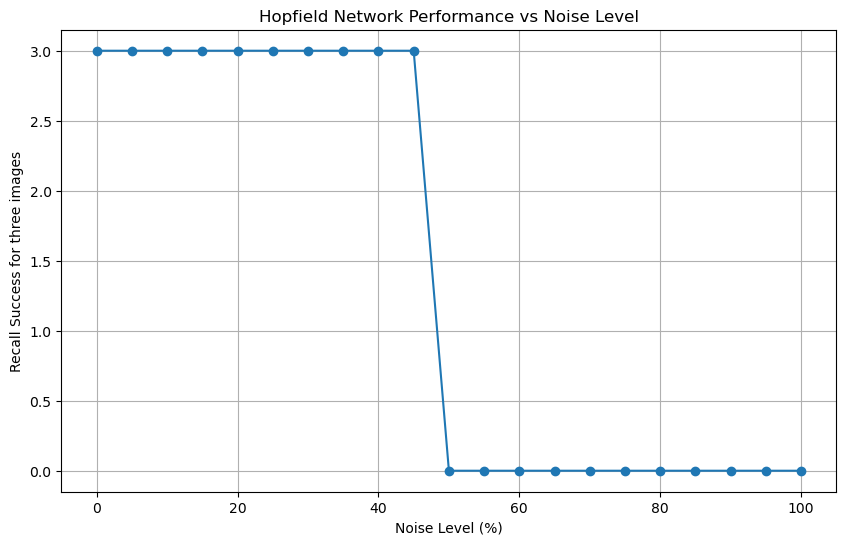

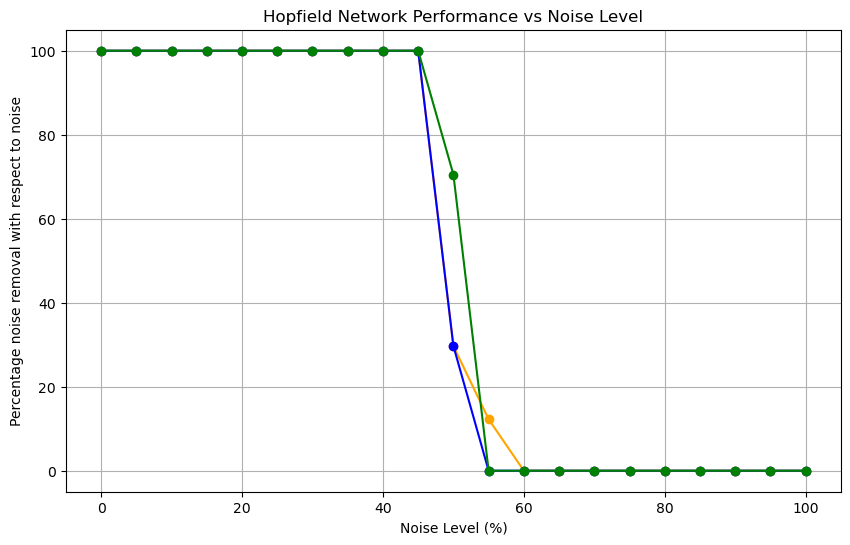

In [169]:
pic_data_3 = pic_data[:3]
pic_net = Hopfield_net(data=pic_data_3)
n = 21
noise_levels = np.linspace(0, 1.0, n)  # 0%, 5%, 10%, ..., 100%
success_hist = []
noise_removal_hist = [[] for _ in range(pic_data_3.shape[0])]



for i, noise_level in enumerate(noise_levels):
    n_successful = 0
    for e in range(pic_data_3.shape[0]):

        noisy_pic = pic_noise(pic_data_3[e], noise_level)
        recalled = pic_net.recall_sync(noisy_pic)
        noise_removal_hist[e].append(calc_noise_removal(original_pic_data=pic_data_3[e],noisy_pic_data=noisy_pic,recalled_pic_data=recalled))

        if np.array_equal(pic_data_3[e], recalled):
            n_successful += 1
    success_hist.append(n_successful)



plt.figure(figsize=(10, 6))
plt.plot(noise_levels * 100, success_hist, marker='o')
plt.xlabel('Noise Level (%)')
plt.ylabel('Recall Success for three images')
plt.title('Hopfield Network Performance vs Noise Level')
plt.grid(True)
plt.show()




plt.figure(figsize=(10, 6))
plt.plot(noise_levels*100, noise_removal_hist[0], marker='o' ,color='orange', label='Image 1')
plt.plot(noise_levels*100, noise_removal_hist[1], marker='o' ,color='blue' , label='Image 2')
plt.plot(noise_levels*100, noise_removal_hist[2], marker='o' ,color='green', label='Image 3')
plt.xlabel('Noise Level (%)')
plt.ylabel('Percentage noise removal with respect to noise')
plt.title('Hopfield Network Performance vs Noise Level')
plt.grid(True)
plt.show()


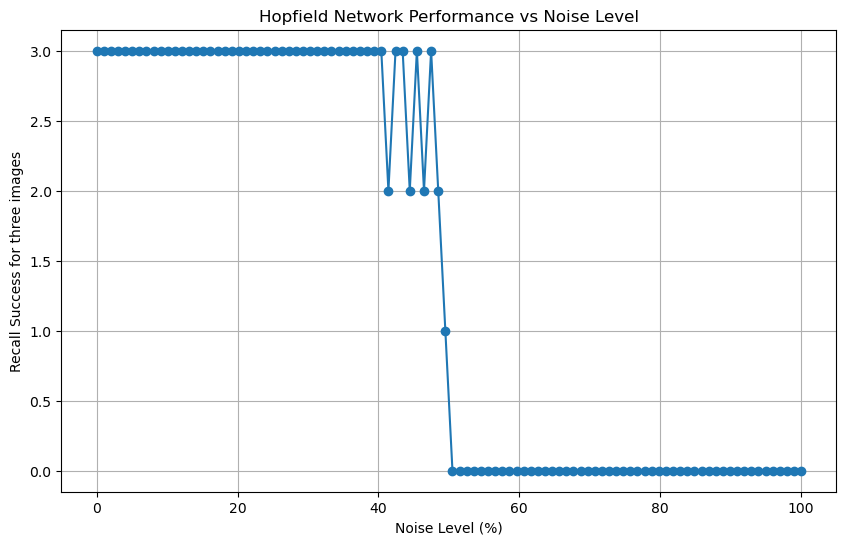

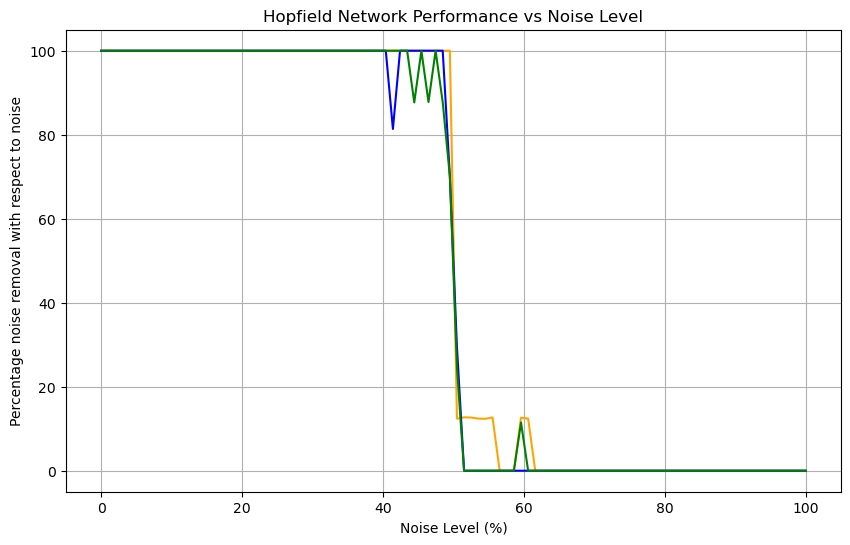

In [170]:
pic_data_3 = pic_data[:3]
pic_net = Hopfield_net(data=pic_data_3)
n = 100
noise_levels = np.linspace(0, 1.0, n)  # 0%, 5%, 10%, ..., 100%
success_hist = []
noise_removal_hist = [[] for _ in range(pic_data_3.shape[0])]



for i, noise_level in enumerate(noise_levels):
    n_successful = 0
    for e in range(pic_data_3.shape[0]):

        noisy_pic = pic_noise(pic_data_3[e], noise_level)
        recalled = pic_net.recall_sync(noisy_pic)
        noise_removal_hist[e].append(calc_noise_removal(original_pic_data=pic_data_3[e],noisy_pic_data=noisy_pic,recalled_pic_data=recalled))

        if np.array_equal(pic_data_3[e], recalled):
            n_successful += 1
    success_hist.append(n_successful)



plt.figure(figsize=(10, 6))
plt.plot(noise_levels * 100, success_hist, marker='o')
plt.xlabel('Noise Level (%)')
plt.ylabel('Recall Success for three images')
plt.title('Hopfield Network Performance vs Noise Level')
plt.grid(True)
plt.show()




plt.figure(figsize=(10, 6))
plt.plot(noise_levels*100, noise_removal_hist[0],color='orange', label='Image 1')
plt.plot(noise_levels*100, noise_removal_hist[1],color='blue' , label='Image 2')
plt.plot(noise_levels*100, noise_removal_hist[2],color='green', label='Image 3')
plt.xlabel('Noise Level (%)')
plt.ylabel('Percentage noise removal with respect to noise')
plt.title('Hopfield Network Performance vs Noise Level')
plt.grid(True)
plt.show()



#### Investigate different number of recall (so far only stopped when network converged)

In [180]:
class Hopfield_net():
    def __init__(self, data, scale=False):
        self.data = data
        self.W = np.zeros((data.shape[1], data.shape[1]))
        self.scale = scale
        self.hebian_learn()

    def hebian_learn(self):
        for i in range(self.data.shape[0]):
            self.W += np.outer(self.data[i], self.data[i])
        if self.scale:
            self.W /= self.data.shape[0]

    # Numpy sign sets sign of 0 to 0 - change it to 1
    def hop_sign(self, dp):
        temp = np.sign(dp)
        return np.where(temp == 0, 1, temp)
    
    def recall_sync(self, dp, n_iterations):
        recall = np.copy(dp)
        for _ in range(n_iterations):
            recall = self.hop_sign(np.matmul(recall, self.W))
        return recall.astype(int)

    def recall_seq(self, dp, random=False):
        order = np.arange(dp.shape[0])
        if random:
            np.random.shuffle(order)
        recall_prev = np.copy(dp)
        recall = self.seq_update(dp, order)
        while not np.array_equal(recall, recall_prev):
            if random:
                np.random.shuffle(order)
            recall_prev = np.copy(recall)
            recall = self.seq_update(recall, order)
        return recall.astype(int)

    # Helper func to sequential update - makes one pass of sequential updates for all points
    def seq_update(self, recall, order):
        ret = np.copy(recall)
        for i in range(order.shape[0]):
            ret[order[i]] = self.hop_sign(np.matmul(self.W[order[i]], ret.transpose()))
        return ret

Testing with 1 iterations...
Testing with 2 iterations...
Testing with 3 iterations...
Testing with 4 iterations...
Testing with 5 iterations...


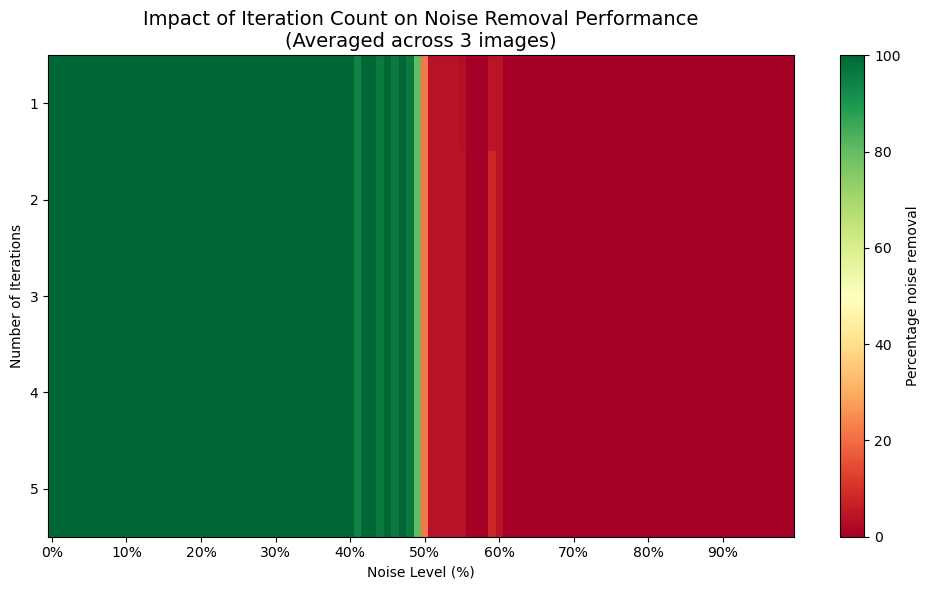

In [183]:
pic_data_3 = pic_data[:3]
pic_net = Hopfield_net(data=pic_data_3)
n = 100
noise_levels = np.linspace(0, 1.0, n)  # 0%, 5%, 10%, ..., 100%
n_iterations = [1,2,3,4,5]

heatmap_data = np.zeros((len(n_iterations),n))


for iter_idx, iterations in enumerate(n_iterations):
    print(f"Testing with {iterations} iterations...")
    
    for noise_idx, noise_level in enumerate(noise_levels):
        noise_removal_for_images = []
        
        for img_idx in range(pic_data_3.shape[0]):
            noisy_pic = pic_noise(pic_data_3[img_idx], noise_level)
            recalled = pic_net.recall_sync(noisy_pic, n_iterations=iterations)
            
            noise_removal = calc_noise_removal(
                original_pic_data=pic_data_3[img_idx],
                noisy_pic_data=noisy_pic,
                recalled_pic_data=recalled
            )
            noise_removal_for_images.append(noise_removal)
        
        heatmap_data[iter_idx, noise_idx] = np.mean(noise_removal_for_images)

plt.figure(figsize=(10, 6))
plt.imshow(heatmap_data, cmap='RdYlGn', aspect='auto')
plt.xticks(np.arange(0, n, step=10), [f'{int(noise_levels[i]*100)}%' for i in range(0, n, 10)])
plt.yticks(np.arange(len(n_iterations)), n_iterations)
plt.colorbar(label='Percentage noise removal')
plt.xlabel('Noise Level (%)')
plt.ylabel('Number of Iterations')
plt.title('Impact of Iteration Count on Noise Removal Performance\n(Averaged across 3 images)', fontsize=14)
plt.tight_layout()
plt.show()
